## Import

In [1]:
from __future__ import print_function
import argparse
import os, time
import random
import matplotlib.pyplot as plt
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.autograd as autograd
import torchvision as tv
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import datasets
from torch.distributions import MultivariateNormal
from torchvision.utils import save_image
from scipy.stats import gaussian_kde

from IPython.display import HTML
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Params

In [2]:
class Options():
    def __init__(self):
        self.dataset = 'mnist'
        self.batchSize = 32
        self.imageSize = 32
        self.nz = 8
        self.nc = 3
        self.nbf = 64
        self.niter = 100
        self.lr = 0.0002
        self.beta1 = 0.5
        self.cuda = True
        self.ngpu = 1
        self.netG = ''
        self.netD = ''
        self.outf = 'cyz'
        self.manualSeed = 1
        self.device = "cuda:1"

opt = Options()

random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
cudnn.benchmark = True

device = torch.device(opt.device if opt.cuda else "cpu")
ngpu = int(opt.ngpu)

## Load data

dataset= mnist


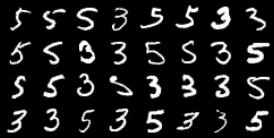

In [3]:
label_list = [3, 5]
#label_list = [0, 7]

def load_data(dataset, all_frac, val_frac, batch_size, label_list): 
    print('dataset=', dataset)
    if dataset == 'mnist':
        opt.nc, opt.nz = 1, 32
        return datasets.load_mnist(all_frac, val_frac, batch_size, img_size=opt.imageSize, label_list=label_list)
    elif dataset == 'cifar10':
        opt.nc, opt.nz = 3, 64
        return datasets.load_cifar10(all_frac, val_frac, batch_size, img_size=opt.imageSize, label_list=label_list)
    else:
        return None
    
def extract(dataloader, n):
    data_list, labels_list = [], []
    with torch.no_grad():
        for i, (data, labels) in enumerate(dataloader):
            data = data.to(device)
            labels = labels.to(device)
            data_list.append(data)
            labels_list.append(labels)
    data = torch.cat(data_list, dim=0)
    labels = torch.cat(labels_list)
    return data[0:n], labels[0:n]

train_loader_all, _, test_loader_all, _ = load_data(opt.dataset, 1.0, 1.0, opt.batchSize, label_list=label_list)
imgs, labels = next(iter(test_loader_all))

grid = tv.utils.make_grid(imgs[0:64], normalize=True)
tv.transforms.ToPILImage()(grid)

## Model

In [4]:
## WGAN: z -> x


nz = opt.nz
bf = opt.nbf
nc = opt.nc
    
class Generator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Z latent vector 100
            nn.ConvTranspose2d(in_channels=nz, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            # State (1024x4x4)
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True))
        self.main2 = nn.Sequential(
            # State (512x8x8)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),
            
            # State (256x16x16)
            nn.ConvTranspose2d(in_channels=256, out_channels=nc, kernel_size=4, stride=2, padding=1))
        self.output = nn.Tanh()

    def forward(self, z): 
        z = z.view(len(z), -1)
        z = z.view(-1, nz, 1, 1)
        out = self.main(z)
        out = self.main2(out)
        out = self.output(out)
        return out
            
class Discriminator(nn.Module):

    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main= nn.Sequential(
            # Image (Cx32x32)
            nn.Conv2d(in_channels=nc, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x16x16)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            #nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x8)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            #nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.output = nn.Sequential(
            nn.Conv2d(1024, 1, 4, 1, 0)
        )

    def forward(self, x):
        x = self.main(x)
        y = self.output(x).view(-1)
        return y
    
    def score(self, x):
        x = self.main(x)
        y = self.output(x).view(-1)
        return y
                
def sample_z(n):
    z = torch.randn(n, nz, 1, 1, device=device)
    return z
        
def gradient_penalty(netD, real, fake):
    alpha = torch.rand(len(real), 1,1,1, device=device).expand(real.size())
    interpolates= (alpha*real + (1-alpha)*fake)
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    D_interpolates = netD(interpolates)
    gradients = autograd.grad(outputs=D_interpolates, inputs=interpolates ,
                              grad_outputs=torch.ones(D_interpolates.size(), device=device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp
    
def train(dataloader, netG, netD):
    
    fixed_noise = sample_z(opt.batchSize)
    
    optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))
    optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))

    netD.train()
    netG.train()
    
    for epoch in range(opt.niter):        
        for i, data in enumerate(dataloader, 0):
            
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################

            k = 5
            for _ in range(k):
                # train with real
                netD.zero_grad()
                real = data[0].to(device)
                batch_size = len(real)
                output = netD(real)
                errD_real = output.mean()
                D_x = output.mean().item()

                # train with fake
                noise = sample_z(len(real))
                fake = netG(noise)
                output = netD(fake.detach())
                errD_fake = output.mean()
                D_G_z1 = output.mean().item()

                # gradient penalty
                gp = gradient_penalty(netD, real.data, fake.data)
                
                # combine real + fake error
                errD = errD_fake - errD_real + 10*gp
                errD.backward()
                optimizerD.step()
            
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################

            netG.zero_grad()
            noise = sample_z(len(real))
            fake = netG(noise)
            output = netD(fake)
            errG_fake = output.mean()
            errG = -errG_fake
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

        # do checkpointing
        if epoch%10 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f %.4f D(x): %.4f D(G(z)): %.4f / %.4f GP: %.4f'
                  % (epoch, opt.niter, i, len(dataloader),
                     errD.item(), errG.item(), 0.0, D_x, D_G_z1, D_G_z2, gp.item()))
        
        
            vutils.save_image(real,
                    '%s/real_samples.png' % opt.outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
                    normalize=True)
            torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
            torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))
    print('\n')

In [5]:
## Classifier: x -> y

class Classifier(nn.Module):

    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main= nn.Sequential(
            # Image (Cx32x32)
            nn.Conv2d(in_channels=nc, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x16x16)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x8)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.output = nn.Sequential(
            nn.Conv2d(1024, 1, 4, 1, 0)
        )

    def forward(self, x):
        x = self.main(x)
        y = self.output(x).view(-1)
        return torch.sigmoid(y)
    
    def score(self, x):
        x = self.main(x)
        y = self.output(x).view(-1)
        return y


def train_classifier(dataloader, netC):
    criterion = nn.BCELoss()
    optimizerC = optim.Adam(netC.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-3)
    netC.train()
    for epoch in range(opt.niter):
        for i, data in enumerate(dataloader, 0):
            netC.zero_grad()
            image = data[0].to(device)
            label = data[1].to(device).float()
            output = netC(image)
            loss = criterion(output, label)
            loss.backward()
            optimizerC.step()
        
        # do checkpointing
        if epoch%10 == 0:
            print('epoch %d Loss_C: %.4f' % (epoch, loss.item()))
    print('\n')

## Train

In [6]:
TRAIN = False

netG = Generator(opt.ngpu).to(device)
netD = Discriminator(opt.ngpu).to(device)
netC = Classifier(opt.ngpu).to(device)

if TRAIN:
    train(train_loader_all, netG, netD)
    train_classifier(train_loader_all, netC)

    torch.save(netG.state_dict(), 'models/{}_DGAN_G_{}.attack'.format(opt.dataset, nz))
    torch.save(netD.state_dict(), 'models/{}_DGAN_D_{}.attack'.format(opt.dataset, nz))
    torch.save(netC.state_dict(), 'models/{}_DGAN_C_{}.attack'.format(opt.dataset, nz))
else:
    netG.load_state_dict(torch.load('models/{}_DGAN_G_{}.attack'.format(opt.dataset, nz)))
    netD.load_state_dict(torch.load('models/{}_DGAN_D_{}.attack'.format(opt.dataset, nz)))
    netC.load_state_dict(torch.load('models/{}_DGAN_C_{}.attack'.format(opt.dataset, nz)))
    
netG.eval()
netD.eval()
netC.eval()

Classifier(
  (main): Sequential(
    (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (output): Sequential(
    (0): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

## Test

In [7]:
def visualize(n, netG, title):
    z_list = []
    z = torch.randn(n, nz).to(device)
    with torch.no_grad():
        netG.eval()
        x = netG(z)
    save_image(x, title, nrow=8, normalize=True)
    
def check_accuracy(x, y, netC):
    pred = netC(x).gt(0.5)
    correct_n = len(pred.eq(y).nonzero().view(-1))
    print('acc=', correct_n/len(y))
    
visualize(n=64, netG=netG, title='net.png')

X, Y = extract(test_loader_all, n=3000)  
check_accuracy(X, Y, netC)

acc= 0.9936908517350158


## Solve z

In [8]:
## Amortized attack --- auxilary encoder

class Encoder(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main= nn.Sequential(
            # Image (Cx32x32)
            nn.Conv2d(in_channels=nc, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x16x16)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x8)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.output = nn.Sequential(
            nn.Conv2d(1024, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, nz*2, 1)
        )   

    def forward(self, x):
        out =  self.main(x)
        out2 = self.output(out).view(len(x), -1)
        return out2
    
def loss_function(recon_x, x):
    recon_x, x = recon_x/2+0.5, x/2+0.5
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    return BCE

def encode(x, netE):
    with torch.no_grad():
        mu_logvar = netE(x)
        z = mu_logvar[:, 0:nz]
        return z
    
def train(dataloader, netE, netD):
        
    netE.train()
    optimizerE = optim.Adam(netE.parameters(), lr=0.0002, betas=(0.5, 0.99))

    for epoch in range(1, opt.niter):
        for batch_idx, (data, labels) in enumerate(dataloader):
            # preparation
            data = data.to(device)
            labels = labels.to(device)
            N = data.shape[0]
     
            # compute reconstruction
            z = netE(data)[:, 0:nz]         
            data_recon = netD(z)

            # optimize!
            optimizerE.zero_grad()
            loss = loss_function(data_recon, data)
            loss.backward()
            optimizerE.step()
            
        # report
        if epoch % 5 ==0:
            print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, loss.item())) 
    print('\n')
    
    
TRAIN = False

netE = Encoder(ngpu).to(device)
if TRAIN:
    train(train_loader_all, netE, netG)
    torch.save(netE.state_dict(), 'models/{}_DGAN_E_{}.attack'.format(opt.dataset, nz))
else:
    netE.load_state_dict(torch.load('models/{}_DGAN_E_{}.attack'.format(opt.dataset, nz)))
    
netE.eval()

Encoder(
  (main): Sequential(
    (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (output): Sequential(
    (0): Conv2d(1024, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  )
)

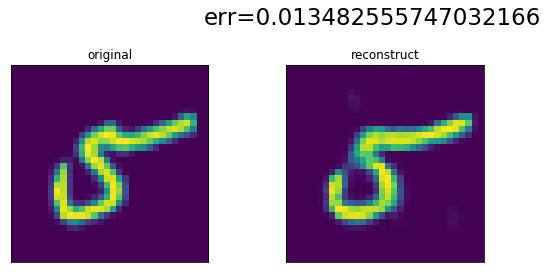

In [19]:
## Inversion: z = argmin |G(z) - x|^2_2

def solve_z(netG, x, R=15, L=200, use_amortized=False):
    n, d = len(x), opt.imageSize*opt.imageSize*opt.nc
    netG.eval()
    if use_amortized:
        z = encode(x, netE).repeat(1, 1).clone().detach().requires_grad_(True)
    else:
        z = torch.randn(R, nz, device=device).clone().detach().requires_grad_(True)
    optimizer = optim.Adam([z], lr=0.01, betas=(0.5, 0.99))
    for l in range(L):
        optimizer.zero_grad()
        loss_x, _ = x_loss(x.view(n, -1).repeat(R, 1), netG(z))
        loss = loss_x
        Loss = torch.mean(loss, dim=0)
        Loss.backward()
        optimizer.step()
        
    val, idx = torch.min(loss, dim=0)
    return z[idx:idx+1], loss[idx].item()

def x_loss(x, x_rec):
    n, d = len(x), opt.imageSize*opt.imageSize*opt.nc
    mse = torch.norm(x.view(n, -1)-x_rec.view(n, -1), dim=1)**2/d
    return mse, mse

def draw_img(x, x_rec, title, subtitle, subtitle2):
    fig=plt.figure(figsize=(14,8))
    fig.suptitle(title,fontsize=23)

    ax=fig.add_subplot(231)
    plt.title(subtitle)
    CS=plt.imshow(tv.transforms.ToPILImage()(x.view(nc, opt.imageSize, opt.imageSize).cpu()/2+0.5))
    ax.set_xticks([])
    ax.set_yticks([])

    ax=fig.add_subplot(232)
    plt.title(subtitle2)
    CS=plt.imshow(tv.transforms.ToPILImage()(x_rec.view(nc, opt.imageSize, opt.imageSize).cpu()/2+0.5))
    ax.set_xticks([])
    ax.set_yticks([])
    
X, Y = extract(test_loader_all, n=1000)
index = (torch.rand(1)*1000).int().item()
x = X[index:index+1]

z, err = solve_z(netG, x.clone().detach(), R=15, L=1500)
x_rec = netG(z)
y = netC(x_rec)
draw_img(x=x, x_rec=x_rec, title='err={}'.format(err), subtitle='original', subtitle2='reconstruct')

## Attack

step:  success_rate= 1.0 distortion= 0.12634114921092987
next beta= tensor([0.0050], device='cuda:1')

 

step:  success_rate= 1.0 distortion= 0.1009344607591629
next beta= tensor([0.0025], device='cuda:1')

 

step:  success_rate= 1.0 distortion= 0.1009344607591629
next beta= tensor([0.0012], device='cuda:1')

 

step:  success_rate= 0.0 distortion= 0.1009344607591629
next beta= tensor([0.0019], device='cuda:1')

 

step:  success_rate= 0.0 distortion= 0.1009344607591629
next beta= tensor([0.0022], device='cuda:1')

 

adv mse= tensor([0.1009], device='cuda:1')
y= tensor([1], device='cuda:1')
average l2 distortion= 0.1009344607591629 

pred_y= tensor([0.5071], device='cuda:1', grad_fn=<SigmoidBackward>)


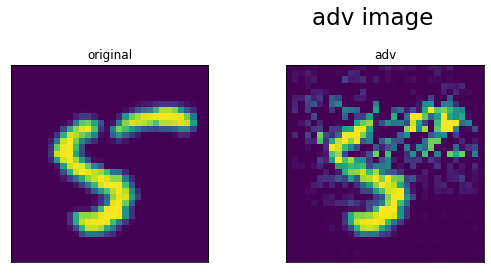

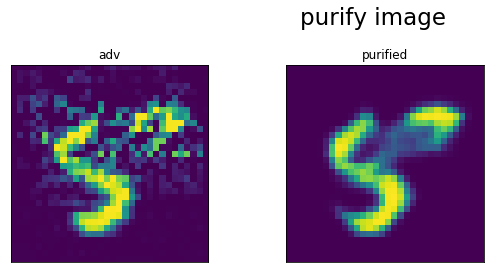

In [18]:
## BPDA

ATK_BETA = 1e-2   
ATK_OUTER_T = 50
ATK_INNER_T = 1500
ATK_LR = 0.01  
ATK_BINARY_SEARCH = 5

def CW_loss(y, x, netC):
    ATK_CONFIDENCE = 0.05
    y_pred = netC.score(x)
    loss_cw = (1-y)*F.relu(0.0-y_pred+ATK_CONFIDENCE) + y*F.relu(y_pred-0.0+ATK_CONFIDENCE)
    success_condition = (1-y)*(0.0<y_pred-ATK_CONFIDENCE) + y*(y_pred<0.0-ATK_CONFIDENCE)
    return loss_cw, success_condition

def G_loss(x, z, netG):
    loss_G, loss_G = x_loss(x, netG(z))
    return loss_G, loss_G

def D_loss(x, x_adv):
    loss_D, loss_D = x_loss(x, x_adv)
    return loss_D, loss_D

def attack_batch(x, y, netG, netC):
 
    n = len(x)
    x = x.clone().detach()
    x_adv = x.clone().detach().requires_grad_(True)
  
    beta = torch.zeros(len(x)).to(x.device) + ATK_BETA
    lower_beta, upper_beta = torch.zeros(n).to(x.device), torch.zeros(len(x)).to(x.device)+1e9  
    best_adv_x = torch.zeros_like(x).detach().to(x.device)
    best_adv_norm = torch.zeros(n).detach().to(x.device)+1.0
    best_z = torch.randn(len(x_adv), nz, device=device)
    history_success_flag = 0*(y>0).int().view(-1)
    acc = 0
    BINARY_T = 0

    while BINARY_T<ATK_BINARY_SEARCH:
            BINARY_T += 1
            success_flag = 0*(y>0).int().view(-1)

            for T in range(ATK_OUTER_T):
                x_adv = x_adv.clone().detach().requires_grad_(True)

                # z-step
                z, err = solve_z(netG, x_adv.clone().detach(), R=15, L=ATK_INNER_T, use_amortized=False)
                    
                # record the best attack so far
                x_adv_tmp = netG(z).clone().detach().requires_grad_(True)
                loss_D, D = D_loss(x, x_adv)
                loss_CW, sf = CW_loss(y, x_adv_tmp, netC)
                idx = ((sf==1).int() * (D<best_adv_norm).int()).nonzero().view(-1)
                best_adv_x[idx] = x_adv[idx].clone()
                best_adv_norm[idx] = D[idx].clone()
                best_z[idx] = z[idx].clone()
                success_flag = success_flag.view(-1).int() | sf.view(-1).int()
                history_success_flag = history_success_flag.view(-1).int() | success_flag.view(-1).int()
                                           
                # x-step
                loss_D, _ = D_loss(x, x_adv)
                loss_CW, _ = CW_loss(y, x_adv_tmp, netC)
                loss = torch.mean(loss_D + beta*loss_CW)
                loss.backward()   
                grad_x = torch.sign(x_adv.grad.data + x_adv_tmp.grad.data)
                LR = 0.04*(1-T/ATK_OUTER_T) + 0.005
                x_adv.data = x_adv.data - LR*torch.sign(grad_x)
                x_adv.data = torch.clamp(x_adv.data, min=-1.0, max=1.0)
                                        
            # change beta
            new_beta_when_success = (beta + lower_beta)/2
            new_beta_when_failure = torch.min(beta*5, upper_beta)/2 + beta/2
            upper_beta = torch.where(success_flag==1, beta, upper_beta)
            lower_beta = torch.where(success_flag==0, beta, lower_beta)
            beta = torch.where(success_flag==1, new_beta_when_success, new_beta_when_failure)
            
            # print results
            print('step:', ' success_rate=', success_flag.sum().item()/n, 'distortion=', torch.mean(best_adv_norm).item())
            print('next beta=', beta)
            print('\n \n')
    return best_adv_x.clone().detach(), best_adv_norm.clone().detach(), best_z.clone()

def attack(x_population, y_population, netG, netC):
    bs = 1
    n_bs = max(int(len(x_population)/bs), 1)
    x_chunks, y_chunks = torch.chunk(x_population, n_bs), torch.chunk(y_population, n_bs)
    x_adv_population, norm_adv_population, z_population = [], [], []
    for i in range(len(x_chunks)):
        t1 = time.time()
        x, y = x_chunks[i], y_chunks[i]
        x_adv, norm, z_adv = attack_batch(x, y, netG, netC)
        x_adv_population.append(x_adv)
        norm_adv_population.append(norm)
        z_population.append(z_adv)
        t2 = time.time()
        print('finish: {}/{}'.format(i, len(x_chunks)), file=open('progress_DGAN_BPDA.txt', 'w'))
    x_adv_population, norm_adv_population = torch.cat(x_adv_population, dim=0), torch.cat(norm_adv_population, dim=0)
    z_porpulation = torch.cat(z_population, dim=0)
    return x_adv_population, norm_adv_population, z_porpulation
    
# ----------------------------------------------------------------------------------------------------------- #
    
# Preparation
X, Y = extract(test_loader_all, n=500)
x, y = X[1:2], Y[1:2]
n, d = len(x), opt.imageSize*opt.imageSize*opt.nc

# Attack
x_adv, distortion_adv, z_adv = attack(x, y, netG, netC)
# SAVE = False
# if SAVE:
#     results = {'x_adv': x_adv.cpu(), 'distortion_adv': distortion_adv.cpu()}
#     torch.save(results, 'results/{}_DGAN_{}_BPDA.attack'.format(opt.dataset, nz))
# else:
#     results = torch.load('results/{}_DGAN_{}_BPDA.attack'.format(opt.dataset, nz))
#     x_adv, distortion_adv = results.get('x_adv').to(device), results.get('distortion_adv')
avg_distortion = torch.mean(distortion_adv).item()
save_image(x, 'clean.png', nrow=len(x), normalize=True)
save_image(x_adv, 'ZX-adv.png', nrow=len(x_adv), normalize=True)
print('adv mse=', distortion_adv)
print('y=', y)
print('average l2 distortion=', avg_distortion, '\n')

# Display
idx = 0
draw_img(x[idx:idx+1], x_adv[idx:idx+1], 'adv image', subtitle='original', subtitle2='adv')
z, err = solve_z(netG, x_adv[idx:idx+1], R=15, L=1500)
x_rec = netG(z)
draw_img(x_adv[idx:idx+1], x_rec, 'purify image', subtitle='adv', subtitle2='purified')
print('pred_y=', netC(netG(z)))

step:  success_rate= 1.0 distortion= 0.053214672952890396
next beta= tensor([0.0050], device='cuda:1')

 

step:  success_rate= 1.0 distortion= 0.053214672952890396
next beta= tensor([0.0075], device='cuda:1')

 

step:  success_rate= 1.0 distortion= 0.04268374294042587
next beta= tensor([0.0062], device='cuda:1')

 

step:  success_rate= 1.0 distortion= 0.04268374294042587
next beta= tensor([0.0056], device='cuda:1')

 

step:  success_rate= 1.0 distortion= 0.04268374294042587
next beta= tensor([0.0059], device='cuda:1')

 

adv mse= tensor([0.0427], device='cuda:1')
y= tensor([1], device='cuda:1')
average l2 distortion= 0.04268374294042587 

pred_y= tensor([0.4896], device='cuda:1', grad_fn=<SigmoidBackward>)


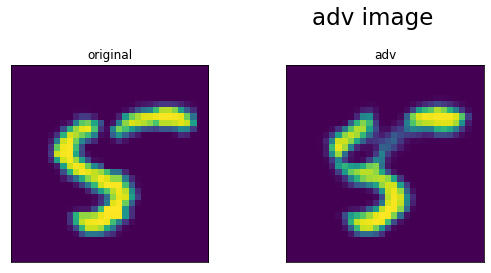

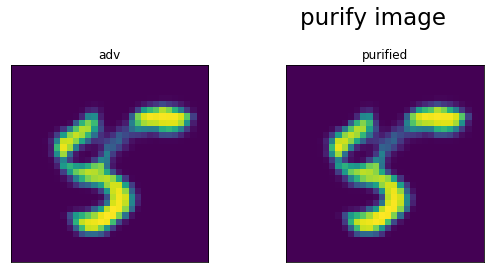

In [15]:
## Reparam attack

ATK_BETA = 1e-2   
ATK_OUTER_T = 50
ATK_INNER_T = 1500
ATK_LR = 0.01  
ATK_BINARY_SEARCH = 5

def CW_loss(y, x, netC):
    ATK_CONFIDENCE = 0.05
    y_pred = netC.score(x)
    loss_cw = (1-y)*F.relu(0.0-y_pred+ATK_CONFIDENCE) + y*F.relu(y_pred-0.0+ATK_CONFIDENCE)
    success_condition = (1-y)*(0.0<y_pred-ATK_CONFIDENCE) + y*(y_pred<0.0-ATK_CONFIDENCE)
    return loss_cw, success_condition

def G_loss(x, z, netG):
    loss_G, loss_G = x_loss(x, netG(z))
    return loss_G, loss_G

def D_loss(x, x_adv):
    loss_D, loss_D = x_loss(x, x_adv)
    return loss_D, loss_D
    
# ----------------------------------------------------------------------------------------------------------- #

def attack_batch(x, y, netG, netC):
    
    n = len(x)
    x = x.clone().detach()
    z = torch.randn(n, nz, device=device).requires_grad_(True)
  
    beta = torch.zeros(n).to(x.device) + ATK_BETA
    lower_beta, upper_beta = torch.zeros(len(x)).to(x.device), torch.zeros(n).to(x.device)+1e9  
    best_adv_x = torch.zeros_like(x).detach().to(x.device)
    best_adv_norm = torch.zeros(n).detach().to(x.device)+1.0
    best_z = torch.randn(n, nz, device=device)
    history_success_flag = 0*(y>0).int().view(-1)
    acc = 0
    BINARY_T = 0

    while BINARY_T<ATK_BINARY_SEARCH:
            BINARY_T += 1
            
            # solve z* using diff init
            R = 30
            z = torch.randn(R, nz, device=device).clone().detach().requires_grad_(True)
            optimizer_z = torch.optim.Adam([{'params': z}], lr=ATK_LR, betas=(0.5, 0.99))
            for T in range(ATK_INNER_T):
                netG.zero_grad()
                netC.zero_grad()
                optimizer_z.zero_grad()                
                x_adv = netG(z)
                loss_D, _ = D_loss(x.view(1, -1).repeat(R, 1), x_adv)
                loss_CW, _ = CW_loss(y.repeat(R, 1).view(-1), netG(z), netC)
                loss = loss_D + beta*loss_CW 
                Loss = torch.mean(loss)
                Loss.backward()
                optimizer_z.step()
            val, idx = torch.min(loss, dim=0)
            x_adv = netG(z[idx])
               
            # record the best attack so far
            _, D = D_loss(x, x_adv)
            _, success_flag = CW_loss(y, x_adv, netC)
            idx = ((success_flag==1).int() * (D<best_adv_norm).int()).nonzero().view(-1)
            best_adv_x[idx] = x_adv[idx].clone()
            best_adv_norm[idx] = D[idx].clone()
            best_z[idx] = z[idx].clone()
            history_success_flag = history_success_flag.view(-1).int() | success_flag.view(-1).int()
                                
            # change beta
            new_beta_when_success = (beta + lower_beta)/2
            new_beta_when_failure = torch.min(beta*5, upper_beta)/2 + beta/2
            upper_beta = torch.where(success_flag==1, beta, upper_beta)
            lower_beta = torch.where(success_flag==0, beta, lower_beta)
            beta = torch.where(success_flag==1, new_beta_when_success, new_beta_when_failure)
            
            # print results
            print('step:', ' success_rate=', success_flag.sum().item()/n, 'distortion=', torch.mean(best_adv_norm).item())
            print('next beta=', beta)
            print('\n \n')
    return best_adv_x.clone().detach(), best_adv_norm.clone().detach(), best_z.clone().detach()

def attack(x_population, y_population, netG, netC):
    bs = 1
    n_bs = max(int(len(x_population)/bs), 1)
    x_chunks, y_chunks = torch.chunk(x_population, n_bs), torch.chunk(y_population, n_bs)
    x_adv_population, norm_adv_population, z_population = [], [], []
    for i in range(len(x_chunks)):
        t1 = time.time()
        x, y = x_chunks[i], y_chunks[i]
        x_adv, norm, z_adv = attack_batch(x, y, netG, netC)
        x_adv_population.append(x_adv)
        norm_adv_population.append(norm)
        z_population.append(z_adv)
        t2 = time.time()
        print('finish: {}/{}'.format(i, len(x_chunks)), file=open('progress_DGAN_REPARAM.txt', 'w'))
    x_adv_population, norm_adv_population = torch.cat(x_adv_population, dim=0), torch.cat(norm_adv_population, dim=0)
    z_porpulation = torch.cat(z_population, dim=0)
    return x_adv_population, norm_adv_population, z_porpulation

# ----------------------------------------------------------------------------------------------------------- #

# Preparation
X, Y = extract(test_loader_all, n=500)
x, y = X[1:2], Y[1:2]
n, d = len(x), opt.imageSize*opt.imageSize*opt.nc

# Attack
x_adv, distortion_adv, z_adv = attack(x, y, netG, netC)
# SAVE = False
# if SAVE:
#     results = {'x_adv': x_adv.cpu(), 'distortion_adv': distortion_adv.cpu()}
#     torch.save(results, 'results/{}_DGAN_{}_REPARAM.attack'.format(opt.dataset, nz))
# else:
#     results = torch.load('results/{}_DGAN_{}_REPARAM.attack'.format(opt.dataset, nz))
#     x_adv, distortion_adv = results.get('x_adv').to(device), results.get('distortion_adv')
avg_distortion = torch.mean(distortion_adv).item()
save_image(x, 'clean.png', nrow=len(x), normalize=True)
save_image(x_adv, 'ZX-adv.png', nrow=len(x_adv), normalize=True)
print('adv mse=', distortion_adv)
print('y=', y)
print('average l2 distortion=', avg_distortion, '\n')

# Display
idx = 0
draw_img(x[idx:idx+1], x_adv[idx:idx+1], 'adv image', subtitle='original', subtitle2='adv')
z, err = solve_z(netG, x_adv[idx:idx+1], R=15, L=1500)
x_rec = netG(z)
draw_img(x_adv[idx:idx+1], x_rec, 'purify image', subtitle='adv', subtitle2='purified')
print('pred_y=', netC(netG(z)))